# ARIMA model with confidence intervals

### 1. Load libraries

In [ ]:
import numpy as np
import pandas as pd
import os, time
import itertools
from time import time

from pandas import read_csv, Series, DataFrame
from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

from matplotlib.pylab import rcParams
rcParams['font.family'] = 'Ubuntu'
rcParams['lines.linewidth'] = 2.5
rcParams['figure.figsize'] = 14, 4

#pip install pmdarima
import pmdarima as pm # automatic identification of best arima parameters

import arch.unitroot as at # Stationarity test
import warnings

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 2. Load data

In [ ]:
# Input the folder where your data is located here:
data_source_folder = ''

# Load Data
df_consumption = pd.read_csv("{}/consumption_prepared.csv".format(data_source_folder), sep=",", decimal = ',')

df_consumption['date'] = pd.to_datetime(df_consumption['date'])
df_consumption.set_index('date', inplace = True)

df_consumption['consumption'] = df_consumption['consumption'].astype(float)

### 3. Train-test split

In [ ]:
print('The test set contains 20% of the data: {} values.'.format(int(len(df_consumption)*0.2)))

The test set contains 20% of the data: 8736 values.


In [ ]:
train_cons, test_cons = df_consumption.iloc[:35040,:], df_consumption.iloc[35040:, :]

### 4. Model creation
#### Identification step

In [ ]:
# Stationarity tests before differencing
ADF = adfuller(train_cons)
KPSS = kpss(train_cons)
PP = at.PhillipsPerron(train_cons)
print('ADF: {}, KPSS {}, PP: {}'.format(ADF[1], KPSS[1],PP.pvalue ))

ADF: 6.843391771997312e-30, KPSS 0.01, PP: 2.08665845055874e-30


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [ ]:
non_seasonal_diff = pm.arima.ndiffs(train_cons)
seasonal_diff = pm.arima.nsdiffs(train_cons, m = 24)
print('Non-seasonal differencing: {} ; Seasonal differencing: {} '.format(non_seasonal_diff, seasonal_diff))

Non-seasonal differencing: 1 ; Seasonal differencing: 0 


In [ ]:
# create a differenced series
diff = train_cons.diff()

In [ ]:
# Stationarity tests before differencing
ADF = adfuller(diff[1:])
KPSS = kpss(diff[1:])
PP = at.PhillipsPerron(diff[1:])
print('ADF: {}, KPSS {}, PP: {}'.format(ADF[1], KPSS[1],PP.pvalue ))

ADF: 0.0, KPSS 0.1, PP: 0.0


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


### Model estimation

In [ ]:
# Best model:  ARIMA(2,1,2)(1,0,1)[24] 
# ARIMA(5,1,0)(0,0,0)[24] 
# Take only part of training data
train_part = train_cons[-192:]
stepwise_fit = pm.arima.auto_arima(y = train_part, start_Q = 1, max_order = 3, start_P = 2, start_D = 1, d = 1, D = 0, seasonal=True, m = 96, trace=True, stepwise = True,
                                  method='nm', maxiter = 10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(2,0,1)[96] intercept   : AIC=-173.177, Time=11.06 sec
 ARIMA(0,1,0)(0,0,0)[96] intercept   : AIC=-73.069, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[96] intercept   : AIC=inf, Time=1.61 sec
 ARIMA(0,1,1)(0,0,1)[96] intercept   : AIC=-115.094, Time=1.57 sec
 ARIMA(0,1,0)(0,0,0)[96]             : AIC=-74.965, Time=0.02 sec
 ARIMA(2,1,2)(1,0,1)[96] intercept   : AIC=-175.182, Time=2.18 sec
 ARIMA(2,1,2)(0,0,1)[96] intercept   : AIC=-177.187, Time=1.78 sec
 ARIMA(2,1,2)(0,0,0)[96] intercept   : AIC=-179.178, Time=0.04 sec
 ARIMA(2,1,2)(1,0,0)[96] intercept   : AIC=-179.950, Time=1.65 sec
 ARIMA(2,1,2)(2,0,0)[96] intercept   : AIC=-175.172, Time=9.23 sec
 ARIMA(1,1,2)(1,0,0)[96] intercept   : AIC=-180.879, Time=1.67 sec
 ARIMA(1,1,2)(0,0,0)[96] intercept   : AIC=-180.041, Time=0.03 sec
 ARIMA(1,1,2)(2,0,0)[96] intercept   : AIC=-176.051, Time=7.91 sec
 ARIMA(1,1,2)(1,0,1)[96] intercept   : AIC=-176.060, Time=1.89 sec
 ARIMA(1,1,2)(0,0,1)[96] 

In [ ]:
# Parameters of best model
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  192
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 96)   Log Likelihood                  99.123
Date:                             Mon, 14 Jun 2021   AIC                           -190.247
Time:                                     23:38:07   BIC                           -177.238
Sample:                                          0   HQIC                          -184.977
                                             - 192                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9316      0.046     20.474      0.000       0.842       1.021
ma.L1         -0.6391      0.079     -8.048      0.000      -0.795      -0.484
ar.S.L96       0.3905      0.101      3.878      0.000       0.193       0.588
sigma2         0.0205      0.002      8.248      0.000       0.016       0.025
===================================================================================
Ljung-Box (Q):                       38.87   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.52   Prob(JB):                         0.66
Heteroskedasticity (H):               0.98   Skew:                             0.15
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Fit selected ARIMA model on the test set
model_fit = SARIMAX(train_cons, freq = '15T',
                  order=(1,1,1),
                  seasonal_order = (1,0,0,96)).fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


#### Residual check

In [ ]:
model_fit.residuals

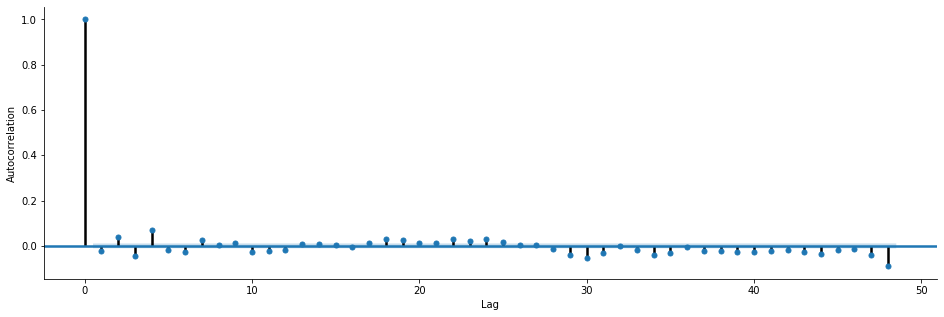

In [ ]:
# Autocorrelation of the variable consumption
plt.rc("figure", figsize=(16,5))
acf_ts = residuals['Residuals'].to_numpy()
acf_plot = plot_acf(acf_ts, lags=48, title = '')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
sns.despine()
plt.show()

<Figure size 2304x432 with 0 Axes>

findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ubuntu'] not found. Falling back to DejaVu Sans.


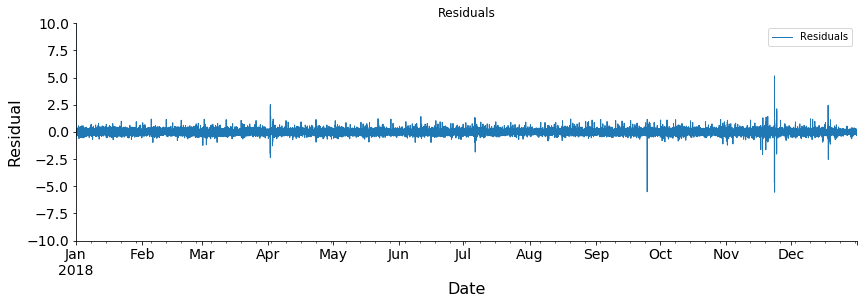

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.columns = ['Residuals']

plt.figure(figsize=(32,6))
plot1 = residuals.plot(title="Residuals", color = 'tab:blue', linewidth = 1)
#residuals.plot(kind='kde', title='Density', ax=ax[1],  color = 'tab:blue', linewidth = 2)
#pxd.set(ylim=(-30, 20))


#plot1.set(xlim=( ))
plt.xlabel("Date", size=16)
plt.ylabel("Residual", size=16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plot1.set(ylim=(-10, 10))
sns.despine()

<Figure size 2304x432 with 0 Axes>

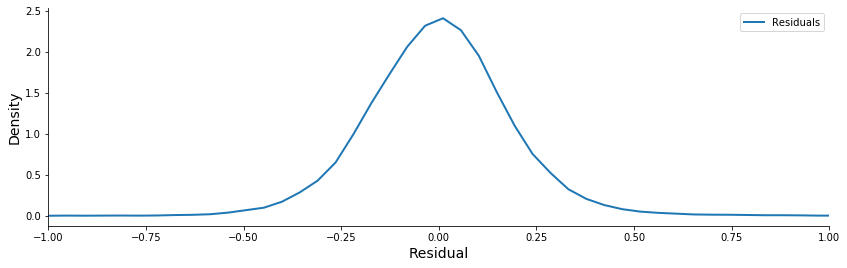

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
residuals.columns = ['Residuals']

plt.figure(figsize=(32,6))
plot2 = residuals.plot(kind='kde', title='Density', color = 'tab:blue', linewidth = 2)
plot2.set(xlim=(-1, 1))
plt.title('')
plt.xlabel("Residual", size=14)
plt.ylabel("Density", size=14)
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)

sns.despine()

### 4. Computation of stepwise 24 hours ahead predictions

In [ ]:
train_cons['consumption'].shape[0]/96

365.0

In [ ]:
warnings.filterwarnings('ignore')
train_y_added = train_cons.copy()
forecasted_values = DataFrame()
conf_int_1 = DataFrame()
conf_int_2 = DataFrame()

for i in range(int(len(test_cons['consumption'])/96)):
    start = (i-1)*96
    end = i*96
    train_y_added = train_y_added.append(test_cons[start:end])
    
    # Fit ARIMA model
    if i == 0:
        model = SARIMAX(train_cons.iloc[-288:,:], freq = '15T',
                  order=(1,1,1),
                  seasonal_order = (1,0,0,96)).fit()    
    else:
        model = SARIMAX(train_y_added[-288:], 
                      order=(1,1,1),
                      seasonal_order = (1,0,0,96)).fit()
    
    
    # Fit ARIMA model
    forecast = model.get_forecast(steps=96)
    yhat = forecast.predicted_mean
    yhat_conf_int1 = forecast.conf_int(alpha=0.4)
    yhat_conf_int2 = forecast.conf_int(alpha=0.6)
    
    # Append new forecasted values
    forecasted_values = forecasted_values.append(pd.DataFrame(yhat))
    yhat_conf_int1.columns = ['q0.2', 'q0.8']
    yhat_conf_int2.columns = ['q0.4', 'q0.6']
    conf_int_1 = conf_int_1.append(yhat_conf_int1)
    conf_int_2 = conf_int_2.append(yhat_conf_int2)
    
    # Monitor progress
    print('Progress: {}%'.format(int(i/int(len(train_cons['consumption'])/96)*100)))
    
forecasted_values.columns = ['mean']  
conf_int_1.columns = ['q0.2', 'q0.8']
conf_int_2.columns = ['q0.4', 'q0.6']
forecasted_values['actuals'] = test_cons['consumption']
df_all = pd.concat([forecasted_values, conf_int_1, conf_int_2], axis = 1)

In [ ]:
# Save predictions
df_all.to_csv('{}/SARIMA_predictions.csv'.format(data_source_folder))

In [ ]:
df_all.columns = ['mean', 'actuals', 'q0.4', 'q0.6', 'q0.2', 'q0.8']
df_all

,mean,actuals,q0.4,q0.6,q0.2,q0.8
2019-01-01 00:00:00,16.464603,15.361607,16.340860,16.588346,16.387501,16.541705
2019-01-01 00:15:00,16.463118,15.478738,16.257911,16.668325,16.335257,16.590979
2019-01-01 00:30:00,16.354926,15.273234,16.068443,16.641409,16.176423,16.533429
2019-01-01 00:45:00,16.248876,15.209941,15.879786,16.617966,16.018902,16.478850
2019-01-01 01:00:00,16.120879,15.142373,15.667998,16.573761,15.838696,16.403063
...,...,...,...,...,...,...
2019-03-31 22:45:00,14.631324,17.553871,8.651399,20.611248,10.905330,18.357318
2019-03-31 23:00:00,14.448938,16.689310,8.431540,20.466336,10.699595,18.198281
2019-03-31 23:15:00,14.356287,16.510600,8.301648,20.410926,10.583740,18.128834
2019-03-31 23:30:00,14.226367,16.391151,8.134714,20.318021,10.430757,18.021978


### Calculate performance of out-of-sample predictions

In [ ]:
def quantile_loss(y_true, y_pred, q):
    return np.max([q*(y_true - y_pred), (1-q)*(y_pred-y_true)], axis=0)

In [ ]:
quantiles = [0.2, 0.4, 0.6, 0.8]
ARIMA_loss_scores = DataFrame()
for i in quantiles:
    ARIMA_loss_scores['q{}'.format(i)] = quantile_loss(df_all['actuals'], df_all['q{}'.format(i)], i)

In [ ]:
ARIMA_loss_scores.mean()

q0.2    1.112999
q0.4    2.741930
q0.6    1.045069
q0.8    1.260657
dtype: float64

In [ ]:
np.mean(ARIMA_loss_scores.mean())

1.5401637666209698